In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.stats as ss
from scipy.optimize import curve_fit
from ntuple_lib import *
beautify_plots(plt)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [17]:
files = ['ntuples_condor/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(1, 10)]
track_num_px = np.array([], dtype='object')
track_num_SCT = np.array([], dtype='object')
track_theta = np.array([], dtype='object')
track_qOverP = np.array([], dtype='object')
track_prob = np.array([], dtype='object')

# recovertex_tracks_idx = np.array([], dtype='object')
# truthvertex_tracks_idx = np.array([], dtype='object')
reco_HS_track_idxs = np.array([], dtype='object')
truth_HS_track_idxs = np.array([], dtype='object')


for file in files:
    root_file = uproot.open(file)
    for key in root_file.keys():
        if key.startswith('EventTree'):
            tree = root_file[key]
            track_num_px = np.concatenate((track_num_px, tree['tracks_numPix'].array(library='np')))
            track_num_SCT = np.concatenate((track_num_SCT, tree['tracks_numSCT'].array(library='np')))
            track_theta = np.concatenate((track_theta, tree['track_theta'].array(library='np')))
            track_qOverP = np.concatenate((track_qOverP, tree['track_qOverP'].array(library='np')))
            track_prob = np.concatenate((track_prob, tree['track_prob'].array(library='np')))
            
            reco_HS_track_idxs  = np.concatenate((reco_HS_track_idxs, tree['recovertex_tracks_idx'].array(library='np')[0]))
            truth_HS_track_idxs = np.concatenate((truth_HS_track_idxs, tree['truthvertex_tracks_idx'].array(library='np')[0]))
            
track_all_si_hits = track_num_px+track_num_SCT
track_eta = np.array([-np.log(np.tan(theta/2)) for theta in track_theta], dtype='object')
track_sin_theta = np.array([np.sin(theta) for theta in track_theta], dtype='object')
track_pT = np.abs(track_sin_theta/track_qOverP)

track_pT_flat = flatten_array(track_pT)
track_eta_flat = flatten_array(track_eta)
track_num_px_flat = flatten_array(track_num_px)
track_prob_flat = flatten_array(track_prob)

reco_HS_track_idxs_flat  = np.array(flatten_array(reco_HS_track_idxs), dtype='int')
truth_HS_track_idxs_flat = np.array(flatten_array(truth_HS_track_idxs), dtype='int')

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


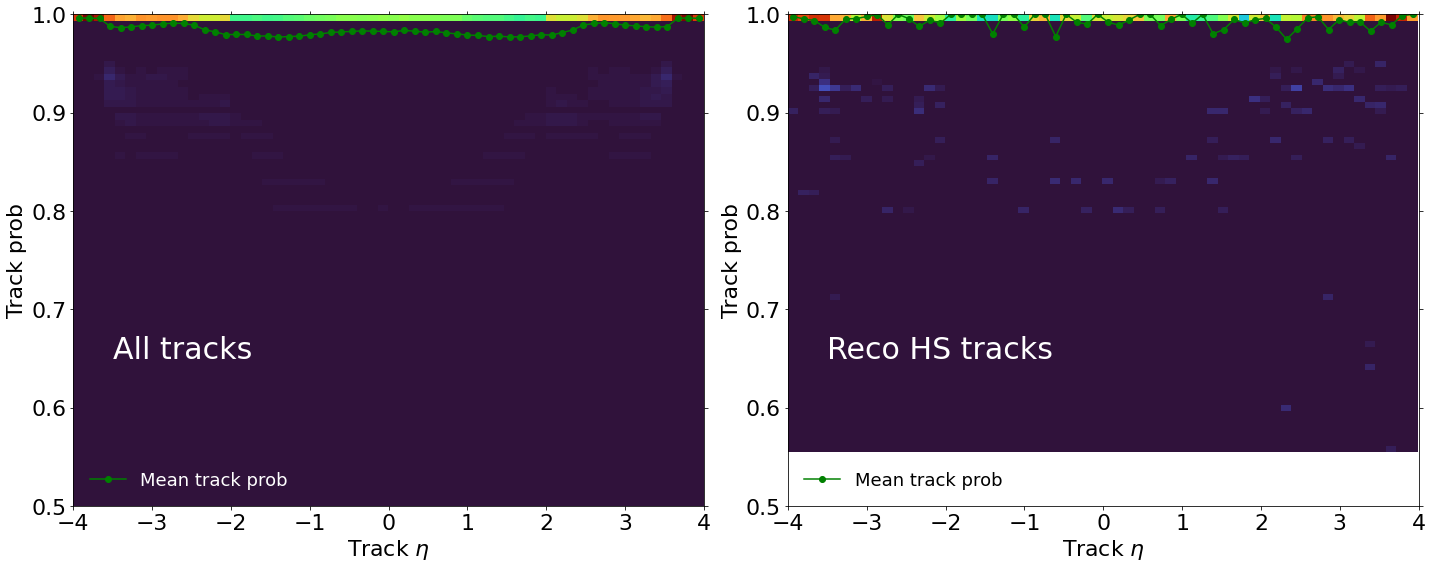

In [42]:
bins = (60, 300)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)


hist = ax1.hist2d(track_eta_flat, track_prob_flat, bins=bins, cmin=0, cmap='turbo')
# fig.colorbar(cm.ScalarMappable(norm = Normalize(np.nanmin(hist[0]), np.nanmax(hist[0])),      cmap='turbo'), ax=ax, label='Number of tracks')

eta_bins = hist[1]
mean_track_prob = binned_mean(track_eta_flat, track_prob_flat, eta_bins)
ax1.plot(eta_bins[:-1]+(eta_bins[1]-eta_bins[0])/2, mean_track_prob, 'og-', label='Mean track prob')

ax1.text(-3.5, 0.65, 'All tracks', fontsize=30, color='white')

ax1.legend(frameon=False, labelcolor='white')
ax1.set_xlabel('Track $\\eta$')
ax1.set_ylabel('Track prob')

ax1.set_xlim(-4, 4)
ax1.set_ylim(0.5, 1)


hist = ax2.hist2d(track_eta_flat[reco_HS_track_idxs_flat], track_prob_flat[reco_HS_track_idxs_flat], bins=(bins[0], 75), cmin=0, cmap='turbo')
# fig.colorbar(cm.ScalarMappable(norm = Normalize(np.nanmin(hist[0]), np.nanmax(hist[0])),      cmap='turbo'), ax=ax, label='Number of tracks')

eta_bins2 = hist[1]
mean_track_prob_HS = binned_mean(track_eta_flat[reco_HS_track_idxs_flat], track_prob_flat[reco_HS_track_idxs_flat], eta_bins2)
ax2.plot(eta_bins2[:-1]+(eta_bins2[1]-eta_bins2[0])/2, mean_track_prob_HS, 'og-', label='Mean track prob')

ax2.text(-3.5, 0.65, 'Reco HS tracks', fontsize=30, color='white')

ax2.legend(frameon=False, labelcolor='k')
ax2.set_xlabel('Track $\\eta$')
ax2.set_ylabel('Track prob')

ax2.set_xlim(-4, 4)
ax2.set_ylim(0.5, 1)

fig.tight_layout()

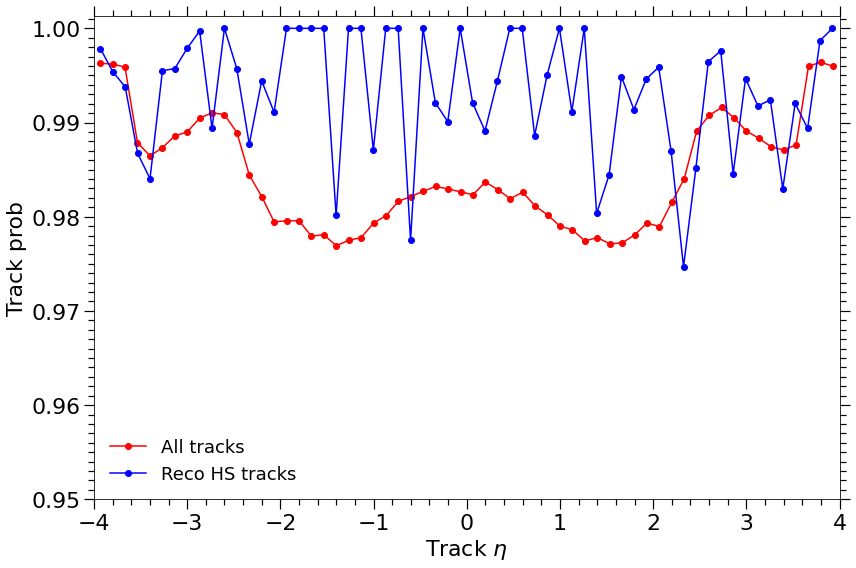

In [43]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

ax.plot(eta_bins[:-1]+(eta_bins[1]-eta_bins[0])/2, mean_track_prob,       'or-', label='All tracks')
ax.plot(eta_bins2[:-1]+(eta_bins2[1]-eta_bins2[0])/2, mean_track_prob_HS, 'ob-', label='Reco HS tracks')

ax.set_xlim(-4, 4)
ax.set_ylim(0.95)
ax.set_xlabel('Track $\\eta$')
ax.set_ylabel('Track prob')

ax.tick_params(which='major', axis='both', length=10, width=1.2)
ax.tick_params(which='minor', axis='both', length=6, width=1.2)
ax.yaxis.set_minor_locator(MultipleLocator(0.001))
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.xaxis.set_major_locator(MultipleLocator(1))


ax.legend(frameon=False)
fig.tight_layout()

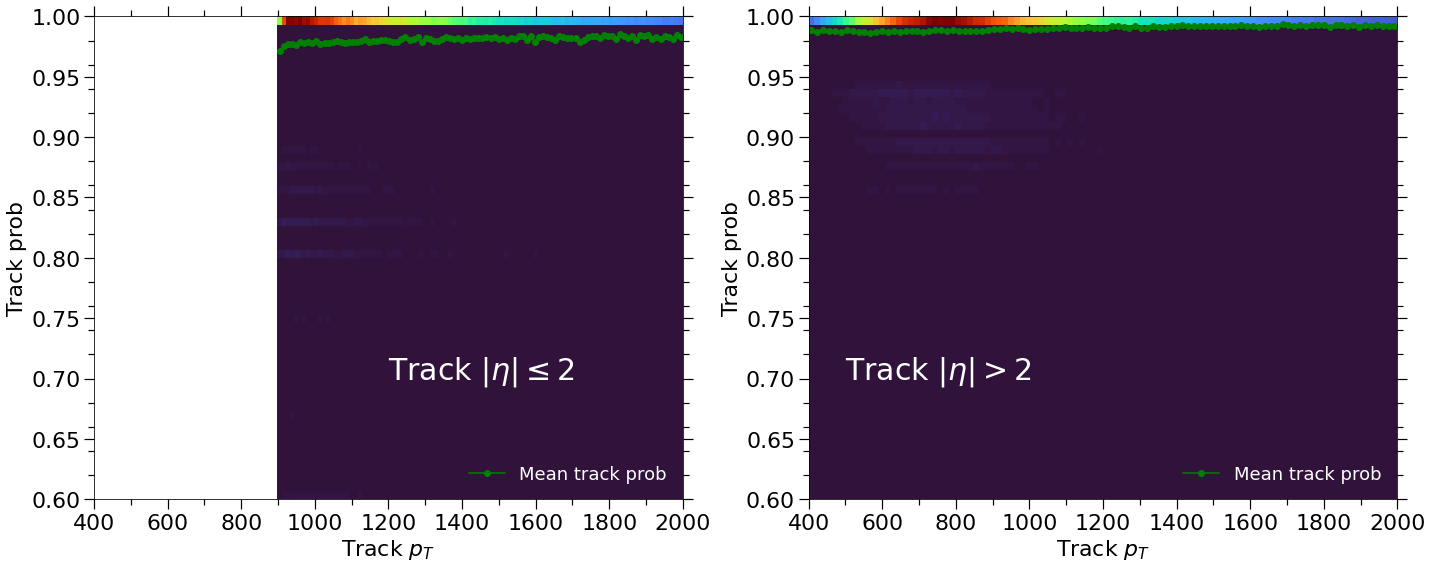

In [59]:
pT_range = 2e3
eta_cutoff = 2

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)

idxs1 = np.logical_and(np.abs(track_pT_flat) < pT_range, np.abs(track_eta_flat) <= eta_cutoff)

hist1 = ax1.hist2d(track_pT_flat[idxs1], track_prob_flat[idxs1], bins=(100, 300), cmin=0, cmap='turbo')
# fig.colorbar(cm.ScalarMappable(norm = Normalize(np.nanmin(hist[0]), np.nanmax(hist[0])),      cmap='turbo'), ax=ax, label='Number of tracks')

pt_bins1 = hist1[1]
mean_track_prob1 = binned_mean(track_pT_flat[idxs1], track_prob_flat[idxs1], pt_bins1)
ax1.plot(pt_bins1[:-1]+(pt_bins1[1]-pt_bins1[0])/2, mean_track_prob1, 'og-', label='Mean track prob')

ax1.text(1200, 0.7, "Track $|\\eta| \\leq {}$".format(eta_cutoff), fontsize=30, color='white')

ax1.legend(frameon=False, labelcolor='white', loc='lower right')
ax1.set_xlabel('Track $p_T$')
ax1.set_ylabel('Track prob')

ax1.set_xlim(400, pT_range)
ax1.set_ylim(0.6, 1)

idxs2 = np.logical_and(np.abs(track_pT_flat) < pT_range, np.abs(track_eta_flat) > eta_cutoff)

hist2 = ax2.hist2d(track_pT_flat[idxs2], track_prob_flat[idxs2], bins=(100, 300), cmin=0, cmap='turbo')
# fig.colorbar(cm.ScalarMappable(norm = Normalize(np.nanmin(hist[0]), np.nanmax(hist[0])),      cmap='turbo'), ax=ax, label='Number of tracks')

pt_bins2 = hist2[1]
mean_track_prob2 = binned_mean(track_pT_flat[idxs2], track_prob_flat[idxs2], pt_bins2)
ax2.plot(pt_bins2[:-1]+(pt_bins2[1]-pt_bins2[0])/2, mean_track_prob2, 'og-', label='Mean track prob')

ax2.text(500, 0.7, "Track $|\\eta| > {}$".format(eta_cutoff), fontsize=30, color='white')

ax2.legend(frameon=False, labelcolor='white', loc='lower right')
ax2.set_xlabel('Track $p_T$')
ax2.set_ylabel('Track prob')

ax2.set_xlim(400, pT_range)
ax2.set_ylim(0.6, 1)

for ax in (ax1, ax2):
    ax.tick_params(which='major', axis='both', length=10, width=1.2)
    ax.tick_params(which='minor', axis='both', length=6, width=1.2)
    ax.yaxis.set_minor_locator(MultipleLocator(0.02))
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.xaxis.set_major_locator(MultipleLocator(200))

fig.tight_layout()

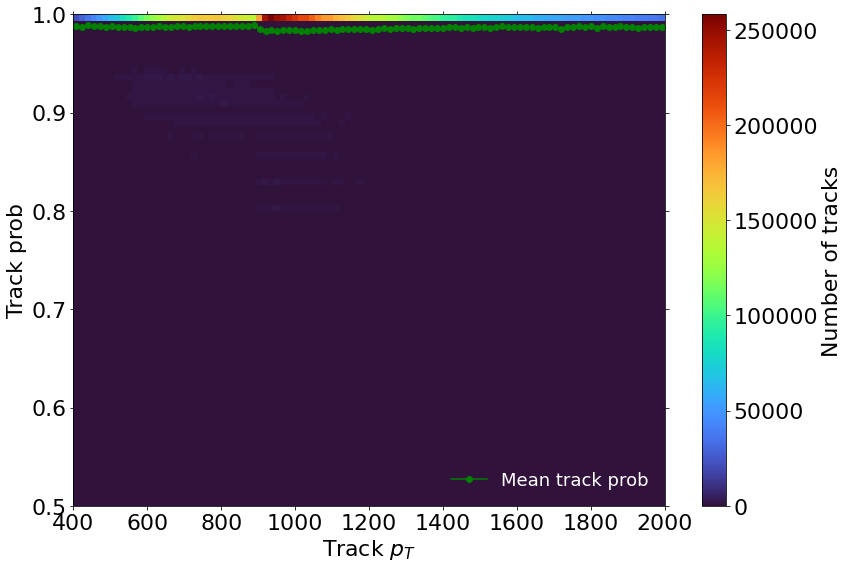

In [55]:
pT_range = 2e3

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

idxs = np.abs(track_pT_flat) < pT_range

hist = ax.hist2d(track_pT_flat[idxs], track_prob_flat[idxs], bins=(100, 300), cmin=0, cmap='turbo')
fig.colorbar(cm.ScalarMappable(norm = Normalize(np.nanmin(hist[0]), np.nanmax(hist[0])),      cmap='turbo'), ax=ax, label='Number of tracks')

pt_bins = hist[1]
mean_track_prob = binned_mean(track_pT_flat[idxs], track_prob_flat[idxs], pt_bins)
ax.plot(pt_bins[:-1]+(pt_bins[1]-pt_bins[0])/2, mean_track_prob, 'og-', label='Mean track prob')

ax.legend(frameon=False, labelcolor='white', loc='lower right')
ax.set_xlabel('Track $p_T$')
ax.set_ylabel('Track prob')

ax.set_xlim(400, pT_range)
ax.set_ylim(0.5, 1)

fig.tight_layout()